# Load the mean (2001-2020) diurnal cycle of sWBGT from ERA5 data, plot diurnal cycle for several locations

In [1]:
local_var = 'swbgt'
timefreq = 'hourly'
data_path  =    '/Users/lukeaparsons/Documents/Manuscripts/CMIP6_HeatPatterns/data/'

In [2]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
from scipy import special #note this is used in Kjellstrom 2018 erf
import time as tm

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

## define the exposure response function parameters to calculate productivity losses from sWBGT

In [3]:
#use Kjellstrom et al., 2018 ERF, also the Watts Lancet Countdown Method

#WorkLoss =  0.5 * (1 + special.erf( (swbgt - WBGTaver) / (WBGTSD * np.sqrt(2))  ) )

WBGTaver = 32.465
WBGTSD = 4.1607

n = 2 #in legacy code, used light, medium, heavy labor- here just using heavy (index 2)


## define function to calculate work time lost based on inputs

In [4]:
def calc_worklost_gwf(oneloc,gwf,local_wp,n):
    
    WBGTaver = 32.465
    WBGTSD = 4.1607
    
    oneloc = oneloc + (local_wp * gwf) #"scale" local temps to gwf
    oneloc = oneloc.T #transpose so can average across correct dimension
    
    oneloc_mean = np.mean(oneloc,axis=0)
    oneloc_max = np.max(oneloc,axis=0)
    oneloc_min = np.min(oneloc,axis=0)
    oneloc_half = (oneloc_mean + oneloc_max)/2
    oneloc_half_min = (oneloc_mean + oneloc_min)/2
    
    WL_mean = 0.5 * (1 + special.erf( (oneloc_mean - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at mean of day
    WL_max = 0.5 * (1 + special.erf( (oneloc_max - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at max
    WL_half = 0.5 * (1 + special.erf( (oneloc_half - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
    WL_half_min = 0.5 * (1 + special.erf( (oneloc_half_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
    WL_min = 0.5 * (1 + special.erf( (oneloc_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)

    timelost = np.empty(oneloc.shape)
    t = 0
    for tt in oneloc:
        WL = 0.5 * (1 + special.erf( (tt - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60
        timelost[t] = WL
        t = t +1
    timelost_sorted = np.flipud(np.sort(timelost))

    hourly_total = np.sum(timelost)
    maxmeanhalf_total = WL_mean + WL_max + WL_half
    meanhalfhalfmin_total = WL_mean  + WL_half + WL_half_min
    meanhalfminmin_total = WL_mean  + WL_half_min + WL_min
    timelost_plot = timelost
    
    return timelost_plot,hourly_total,maxmeanhalf_total,meanhalfhalfmin_total,meanhalfminmin_total,WL_mean,WL_max,WL_half,WL_half_min,WL_min


## load the pre-calculated mean diurnal cycle from ERA5 sWBGT


In [5]:
nc = xr.open_dataset(data_path + 'swbgt_diurnalcycle_2001_2020_Mean.nc')
swbgt = nc[str(local_var)]

lon = swbgt['lon']
lat = swbgt['lat']

#New Delhi is ~28.7N, 77.1E
#Lagos is: 6.5244° N, 3.3792° E
#Qatar is: 51.5 N, 25.25 E
#Kuwait: 29.3759° N, 47.9774° E
#Belem Brazil is: -1.5N, 311.5E
#Atlanta: 33.7490° N, 84.3880° W

## define months for plotting titles later

In [6]:
Months = ['Place Holder month','January','February','March','April','May','June','July','August','September','October','November','December']


## load CMIP6 warming patterns for 'scaling' the diurnal cycle

In [7]:
nc_cmip6pattern = xr.open_dataset(data_path + 'swbgt_patterns_CMIP6_1pctCO2_MMMedian_Annual_monthly_era5_grid.nc')
gwfs = np.arange(0,5,1) #array of global warming additions on top of the 2001-2020 mean

## Load and plot data for Doha, Qatar

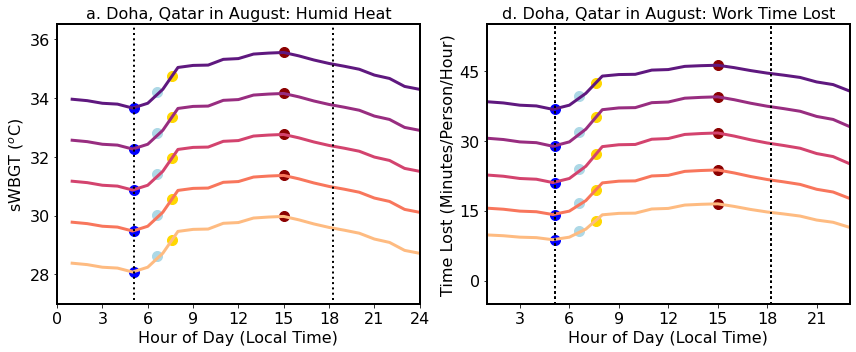

In [8]:
#select lon and lat and month
month = 8
lonloc = 51.5 
latloc = 25.25

swbgt_oneloc = swbgt.sel(lon=lonloc, lat=latloc, method='nearest')
swbgt_oneloc = swbgt_oneloc[month-1,:] #note months are 1-12, but python index is 0-11

oneloc_mean = swbgt_oneloc.values

lon_index = lon.where(lon == lonloc) 
lat_index = lat.where(lat == latloc)

oneloc = oneloc_mean

oneloc_mean = np.mean(oneloc,axis=0)
oneloc_max = np.max(oneloc,axis=0)
oneloc_min = np.min(oneloc,axis=0)
oneloc_half = (oneloc_mean + oneloc_max)/2
oneloc_half_min = (oneloc_mean + oneloc_min)/2

WL_mean = 0.5 * (1 + special.erf( (oneloc_mean - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at mean of day
WL_max = 0.5 * (1 + special.erf( (oneloc_max - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at max
WL_half = 0.5 * (1 + special.erf( (oneloc_half - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_half_min = 0.5 * (1 + special.erf( (oneloc_half_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_min = 0.5 * (1 + special.erf( (oneloc_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)

timelost = np.empty(oneloc.shape)
t = 0
for tt in oneloc:
    WL = 0.5 * (1 + special.erf( (tt - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at quantile 0 
    timelost[t] = WL
    t = t +1
timelost_sorted = np.flipud(np.sort(timelost))

hourly_total = np.sum(timelost)
maxmeanhalf_total = WL_mean + WL_max + WL_half
meanhalfhalfmin_total = WL_mean  + WL_half + WL_half_min
meanhalfminmin_total = WL_mean  + WL_half_min + WL_min

#CMIP6 warming patterns
cmip6_pattern = nc_cmip6pattern[str('slope_month_'+str(month))]
local_wp = cmip6_pattern.sel(lon=lonloc, lat=latloc, method='nearest').values

##now make plot

UTC_offset = 3

oneloc_plot = np.concatenate([oneloc[22:25],oneloc[0:22]],axis=0)
timelost_plot = np.concatenate([timelost[22:25],timelost[0:22]],axis=0)

Sunrise = 5.1
Sunset = 18.25

gwfs = np.arange(4,-1,-1)

colors = plt.cm.magma(np.linspace(0,1,len(gwfs)+3))

dotsize = 100

fig = plt.figure(figsize=(12,5))

MorningDot = Sunrise + 1.5
MeanDot = Sunrise + 2.5
MaxDot = 15

ax = plt.subplot(1,2,1)
gg = 0
for gwf in gwfs:
    if gwf == 0:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T: '+str(gwf)+'$^o$C (Present)'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    else:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T:: '+str(gwf)+'$^o$C'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    gg = gg + 1
plt.plot(np.ones((50,),dtype=int)*Sunrise,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.plot(np.ones((50,),dtype=int)*Sunset,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.xlim([1,23])
plt.ylim([27,36.5])
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('sWBGT ($^o$C)',fontsize=16)
#plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)
#plt.grid()
plt.title('a. Doha, Qatar in '+str(Months[month])+': Humid Heat',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()

ax = plt.subplot(1,2,2)
gg = 0
for gwf in gwfs:
    timelost_plot,hourly_total,maxmeanhalf_total,meanhalfhalfmin_total,meanhalfminmin_total,WL_mean,WL_max,WL_half,WL_half_min,WL_min = calc_worklost_gwf(oneloc_plot,gwf,local_wp,n)
    plt.plot(np.arange(1,25,1),timelost_plot,color=colors[gg+2,:],linewidth=3) #label = 'Hourly Diurnal'
    gg = gg + 1
    if gwf == 0:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue',label='Sunrise (Minimum)')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue',label='Morning')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold',label='Mean of 24hr')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred',label='Mid-Day (Maximum)')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':',label='Sunrise and Sunset')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
    else:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        
    plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
    plt.yticks([0,15,30,45],fontsize=16)
plt.xlim([1,23])
plt.ylim([-5,55])
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('Time Lost (Minutes/Person/Hour)',fontsize=16)
plt.title('d. Doha, Qatar in '+str(Months[month])+': Work Time Lost',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()    

#plt.savefig(FIGUREPATH + 'Figure1a_d_Doha.eps', format='eps')

## Load and plot data for northern India (New Delhi)

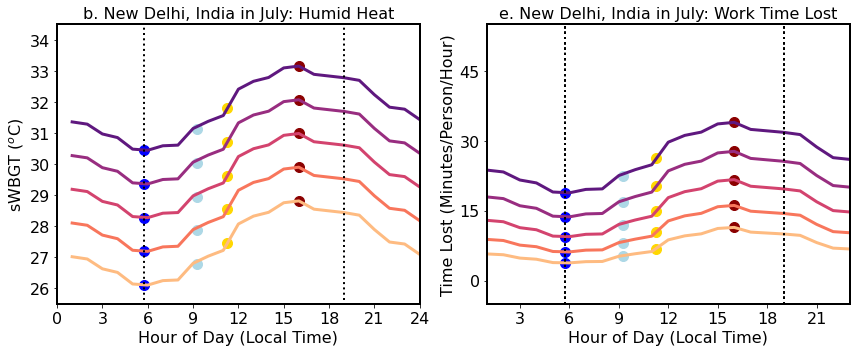

In [9]:
#select lon and lat and month

month = 7

lonloc = 77.1
latloc = 28.7

swbgt_oneloc = swbgt.sel(lon=lonloc, lat=latloc, method='nearest')
swbgt_oneloc = swbgt_oneloc[month-1,:]

oneloc_mean = swbgt_oneloc.values

lon_index = lon.where(lon == lonloc) 
lat_index = lat.where(lat == latloc)

oneloc = oneloc_mean

oneloc_mean = np.mean(oneloc,axis=0)
oneloc_max = np.max(oneloc,axis=0)
oneloc_min = np.min(oneloc,axis=0)
oneloc_half = (oneloc_mean + oneloc_max)/2
oneloc_half_min = (oneloc_mean + oneloc_min)/2

WL_mean = 0.5 * (1 + special.erf( (oneloc_mean - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at mean of day
WL_max = 0.5 * (1 + special.erf( (oneloc_max - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at max
WL_half = 0.5 * (1 + special.erf( (oneloc_half - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_half_min = 0.5 * (1 + special.erf( (oneloc_half_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_min = 0.5 * (1 + special.erf( (oneloc_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)

timelost = np.empty(oneloc.shape)
t = 0
for tt in oneloc:
    WL = 0.5 * (1 + special.erf( (tt - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at quantile 0 
    timelost[t] = WL
    t = t +1
timelost_sorted = np.flipud(np.sort(timelost))

hourly_total = np.sum(timelost)
maxmeanhalf_total = WL_mean + WL_max + WL_half
meanhalfhalfmin_total = WL_mean  + WL_half + WL_half_min
meanhalfminmin_total = WL_mean  + WL_half_min + WL_min

# CMIP6 warming patterns
cmip6_pattern = nc_cmip6pattern[str('slope_month_'+str(month))]
local_wp = cmip6_pattern.sel(lon=lonloc, lat=latloc, method='nearest').values

UTC_offset = 6

oneloc_plot = np.concatenate([oneloc[18:25],oneloc[0:18]],axis=0)
timelost_plot = np.concatenate([timelost[18:25],timelost[0:18]],axis=0)

Sunrise = 5.75
Sunset = 19

gwfs = np.arange(4,-1,-1)


colors = plt.cm.magma(np.linspace(0,1,len(gwfs)+3))

dotsize = 100

fig = plt.figure(figsize=(12,5))

MorningDot = Sunrise + 3.5
MeanDot = Sunrise + 5.5
MaxDot = 16

ax = plt.subplot(1,2,1)
gg = 0
for gwf in gwfs:
    if gwf == 0:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T: '+str(gwf)+'$^o$C (Present)'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    else:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T:: '+str(gwf)+'$^o$C'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    gg = gg + 1
plt.plot(np.ones((50,),dtype=int)*Sunrise,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.plot(np.ones((50,),dtype=int)*Sunset,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.xlim([1,23])
plt.ylim([25.5,34.5])
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('sWBGT ($^o$C)',fontsize=16)
plt.title('b. New Delhi, India in '+str(Months[month])+': Humid Heat',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()

ax = plt.subplot(1,2,2)
gg = 0
for gwf in gwfs:
    timelost_plot,hourly_total,maxmeanhalf_total,meanhalfhalfmin_total,meanhalfminmin_total,WL_mean,WL_max,WL_half,WL_half_min,WL_min = calc_worklost_gwf(oneloc_plot,gwf,local_wp,n)
    plt.plot(np.arange(1,25,1),timelost_plot,color=colors[gg+2,:],linewidth=3) #label = 'Hourly Diurnal'
    gg = gg + 1
    if gwf == 0:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue',label='Sunrise (Minimum)')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue',label='Morning')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold',label='Mean of 24hr')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred',label='Mid-Day (Maximum)')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':',label='Sunrise and Sunset')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
    else:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold')
        #plt.scatter(11,WL_half,s=dotsize,color='orange')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
plt.yticks([0,15,30,45],fontsize=16)
plt.xlim([1,23])
plt.ylim([-5,55])
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('Time Lost (Minutes/Person/Hour)',fontsize=16)
plt.title('e. New Delhi, India in '+str(Months[month])+': Work Time Lost',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()    

#plt.savefig('Figure1b_e_NewDelhi.eps', format='eps')

## now for Atlanta, USA

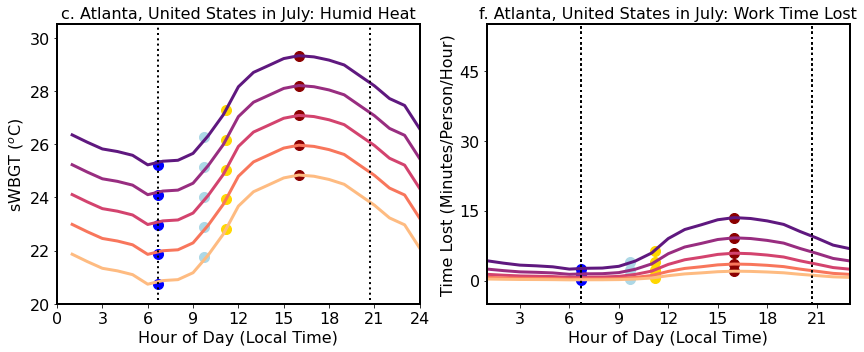

In [10]:
#select lon and lat and month

month = 7

lonloc = 360-84.25
latloc = 33.75

swbgt_oneloc = swbgt.sel(lon=lonloc, lat=latloc, method='nearest')
swbgt_oneloc = swbgt_oneloc[month-1,:]

oneloc_mean = swbgt_oneloc.values

lon_index = lon.where(lon == lonloc) 
lat_index = lat.where(lat == latloc)

oneloc = oneloc_mean

oneloc_mean = np.mean(oneloc,axis=0)
oneloc_max = np.max(oneloc,axis=0)
oneloc_min = np.min(oneloc,axis=0)
oneloc_half = (oneloc_mean + oneloc_max)/2
oneloc_half_min = (oneloc_mean + oneloc_min)/2

WL_mean = 0.5 * (1 + special.erf( (oneloc_mean - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at mean of day
WL_max = 0.5 * (1 + special.erf( (oneloc_max - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at max
WL_half = 0.5 * (1 + special.erf( (oneloc_half - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_half_min = 0.5 * (1 + special.erf( (oneloc_half_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)
WL_min = 0.5 * (1 + special.erf( (oneloc_min - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #4hrs at halfway (mean/max)

timelost = np.empty(oneloc.shape)
t = 0
for tt in oneloc:
    WL = 0.5 * (1 + special.erf( (tt - WBGTaver) / (WBGTSD * np.sqrt(2))  ) ) * 60 #at quantile 0 
    timelost[t] = WL
    t = t +1
timelost_sorted = np.flipud(np.sort(timelost))

hourly_total = np.sum(timelost)
maxmeanhalf_total = WL_mean + WL_max + WL_half
meanhalfhalfmin_total = WL_mean  + WL_half + WL_half_min
meanhalfminmin_total = WL_mean  + WL_half_min + WL_min

# CMIP6 warming patterns
cmip6_pattern = nc_cmip6pattern[str('slope_month_'+str(month))]
local_wp = cmip6_pattern.sel(lon=lonloc, lat=latloc, method='nearest').values

UTC_offset = 21

oneloc_plot = np.concatenate([oneloc[4:25],oneloc[0:4]],axis=0)
timelost_plot = np.concatenate([timelost[4:25],timelost[0:4]],axis=0)

Sunrise = 6.7
Sunset = 20.7

gwfs = np.arange(4,-1,-1)

colors = plt.cm.magma(np.linspace(0,1,len(gwfs)+3))

dotsize = 100

fig = plt.figure(figsize=(12,5))

MorningDot = Sunrise + 3
MeanDot = Sunrise + 4.5
MaxDot = 16

ax = plt.subplot(1,2,1)
gg = 0
for gwf in gwfs:
    if gwf == 0:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T: '+str(gwf)+'$^o$C (Present)'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    else:
        plt.plot(np.arange(1,25,1),np.squeeze(oneloc_plot+local_wp*gwf),color=colors[gg+2,:],linewidth=3,label=str('Global $\Delta$T:: '+str(gwf)+'$^o$C'))#label = 'Hourly Diurnal'
        plt.scatter(Sunrise,oneloc_min+local_wp*gwf,s=dotsize,color='blue')
        plt.scatter(MorningDot,oneloc_half_min+local_wp*gwf,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,oneloc_mean+local_wp*gwf,s=dotsize,color='gold')
        plt.scatter(MaxDot,oneloc_max+local_wp*gwf,s=dotsize,color='darkred')
    gg = gg + 1
plt.plot(np.ones((50,),dtype=int)*Sunrise,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.plot(np.ones((50,),dtype=int)*Sunset,np.arange(0,50,1),linewidth=2,color='k',linestyle=':')
plt.xlim([1,23])
plt.ylim([20,30.5])
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('sWBGT ($^o$C)',fontsize=16)
plt.title('c. Atlanta, United States in '+str(Months[month])+': Humid Heat',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()

ax = plt.subplot(1,2,2)
gg = 0
for gwf in gwfs:
    timelost_plot,hourly_total,maxmeanhalf_total,meanhalfhalfmin_total,meanhalfminmin_total,WL_mean,WL_max,WL_half,WL_half_min,WL_min = calc_worklost_gwf(oneloc_plot,gwf,local_wp,n)
    plt.plot(np.arange(1,25,1),timelost_plot,color=colors[gg+2,:],linewidth=3) #label = 'Hourly Diurnal'
    gg = gg + 1
    if gwf == 0:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue',label='Sunrise (Minimum)')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue',label='Morning')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold',label='Mean of 24hr')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred',label='Mid-Day (Maximum)')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':',label='Sunrise and Sunset')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
    else:
        plt.scatter(Sunrise,WL_min,s=dotsize,color='blue')
        plt.scatter(MorningDot,WL_half_min,s=dotsize,color='lightblue')
        plt.scatter(MeanDot,WL_mean,s=dotsize,color='gold')
        plt.scatter(MaxDot,WL_max,s=dotsize,color='darkred')
        plt.plot(np.ones((65,),dtype=int)*Sunrise,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        plt.plot(np.ones((65,),dtype=int)*Sunset,np.arange(-5,60,1),linewidth=2,color='k',linestyle=':')
        
    plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24],fontsize=16)
    plt.yticks([0,15,30,45],fontsize=16)
plt.xlim([1,23])
plt.ylim([-5,55])
plt.xlabel('Hour of Day (Local Time)',fontsize=16)
plt.ylabel('Time Lost (Minutes/Person/Hour)',fontsize=16)
plt.title('f. Atlanta, United States in '+str(Months[month])+': Work Time Lost',fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.tight_layout()    

#plt.savefig(FIGUREPATH + 'Figure1c_f_Atlanta.eps', format='eps')